# **SEL-NNML Training Visualization - Dataset 1**

This notebook contains visualizations for the SEL-NNML training process, including:
- Training convergence across different samplers (TPE, GP, CMA-ES, QMC)
- Training time comparisons
- Feature importance analysis

## 1. Import Libraries

In [164]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import os
from scipy.signal import savgol_filter

## 2. Load Training Histories

In [165]:
# Ensure files exist and load them
base_path = '../artifacts/ds1/models'
files = {
    'TPE': os.path.join(base_path, 'tpe', 'sel-nnml_training_history.csv'),
    'GP': os.path.join(base_path, 'gp', 'sel-nnml_training_history.csv'),
    'CMA-ES': os.path.join(base_path, 'cmaes', 'sel-nnml_training_history.csv'),
    'QMC': os.path.join(base_path, 'qmc', 'sel-nnml_training_history.csv')
}
for k, p in files.items():
    if not os.path.exists(p):
        raise FileNotFoundError(f"Training history file not found: {p}")

tpe_history = pd.read_csv(files['TPE'])
gp_history = pd.read_csv(files['GP'])
cmaes_history = pd.read_csv(files['CMA-ES'])
qmc_history = pd.read_csv(files['QMC'])

print('Training histories loaded successfully!')
print(f"TPE: {tpe_history.shape}, GP: {gp_history.shape}, CMA-ES: {cmaes_history.shape}, QMC: {qmc_history.shape}")

Training histories loaded successfully!
TPE: (100, 2), GP: (100, 2), CMA-ES: (100, 2), QMC: (100, 2)


## 3. Convergence Chart

This chart shows the cumulative best score over iterations for each sampler.

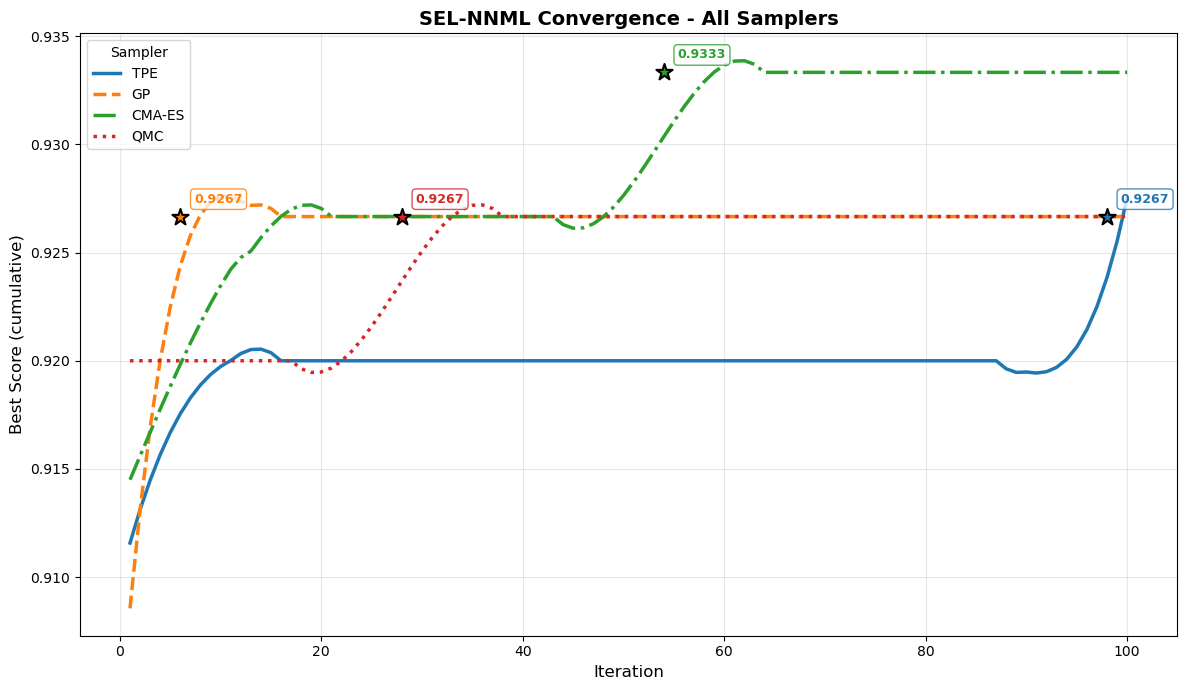

In [166]:
plt.figure(figsize=(12, 7))

samplers = [
    ('TPE', tpe_history, '#1f77b4', '-'),
    ('GP', gp_history, '#ff7f0e', '--'),
    ('CMA-ES', cmaes_history, '#2ca02c', '-.'),
    ('QMC', qmc_history, '#d62728', ':')
]

for name, df, color, linestyle in samplers:
    cumulative_best = df['score'].cummax()
    x = df['iteration'].values
    y = cumulative_best.values
    
    # Apply Savitzky-Golay smoothing
    window_length = min(21, len(y) if len(y) % 2 == 1 else len(y) - 1)
    y_smooth = savgol_filter(y, window_length, 3)
    
    plt.plot(x, y_smooth, label=name, color=color, linewidth=2.5, linestyle=linestyle)
    
    # Highlight peak score
    peak_score = y.max()
    peak_iteration = x[y.argmax()]
    plt.scatter(peak_iteration, peak_score, color=color, s=150, marker='*', 
                edgecolors='black', linewidths=1.5, zorder=5)
    plt.annotate(f'{peak_score:.4f}', 
                xy=(peak_iteration, peak_score),
                xytext=(10, 10), textcoords='offset points',
                fontsize=9, color=color, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=color, alpha=0.8))

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Best Score (cumulative)', fontsize=12)
plt.title('SEL-NNML Convergence - All Samplers', fontsize=14, fontweight='bold')
plt.legend(title='Sampler', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Save Convergence Plot

In [167]:
out_dir = '../artifacts/ds1/visualizations'
os.makedirs(out_dir, exist_ok=True)

plt.figure(figsize=(12, 7))
for name, df, color, linestyle in samplers:
    cumulative_best = df['score'].cummax()
    x = df['iteration'].values
    y = cumulative_best.values
    window_length = min(21, len(y) if len(y) % 2 == 1 else len(y) - 1)
    y_smooth = savgol_filter(y, window_length, 3)
    plt.plot(x, y_smooth, label=name, color=color, linewidth=2.5, linestyle=linestyle)
    peak_score = y.max()
    peak_iteration = x[y.argmax()]
    plt.scatter(peak_iteration, peak_score, color=color, s=150, marker='*', 
                edgecolors='black', linewidths=1.5, zorder=5)
    plt.annotate(f'{peak_score:.4f}', xy=(peak_iteration, peak_score),
                xytext=(10, 10), textcoords='offset points', fontsize=9, 
                color=color, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=color, alpha=0.8))

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Best Score (cumulative)', fontsize=12)
plt.title('SEL-NNML Convergence - All Samplers', fontsize=14, fontweight='bold')
plt.legend(title='Sampler', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
out_path = os.path.join(out_dir, 'sel_nnml_convergence_all_samplers.png')
plt.savefig(out_path, dpi=300, bbox_inches='tight')
print(f'Convergence plot saved to: {out_path}')
plt.close()

Convergence plot saved to: ../artifacts/ds1/visualizations/sel_nnml_convergence_all_samplers.png


## 5. Training Time Comparison

In [168]:
# Load training times
times_path = '../artifacts/ds1/models/training_times.csv'
times_df = pd.read_csv(times_path)
print("Training Times Loaded:")
print(times_df)

Training Times Loaded:
  Sampler  Base Models Training Time (seconds)  \
0     TPE                            93.051321   
1      GP                           256.697985   
2  CMA-ES                            90.717578   
3     QMC                            87.806745   

   Meta Model Training Time (seconds)  Total Training Time (seconds)  
0                          161.484864                     254.536186  
1                          132.536662                     389.234648  
2                          131.479055                     222.196633  
3                          150.151966                     237.958711  


### 5.1 Training Time Summary Table

In [169]:
def seconds_to_hours(seconds):
    hours = seconds / 3600
    if hours < 0.01:
        minutes = seconds / 60
        return f"{minutes:.2f} min"
    return f"{hours:.4f} hrs"

table_data = []
for _, row in times_df.iterrows():
    table_data.append({
        'Method': row['Sampler'],
        'Base Learner Time': seconds_to_hours(row['Base Models Training Time (seconds)']),
        'Meta Learner Time': seconds_to_hours(row['Meta Model Training Time (seconds)']),
        'Total Time': seconds_to_hours(row['Total Training Time (seconds)'])
    })

summary_table = pd.DataFrame(table_data)
print("\n" + "="*80)
print("TRAINING TIME COMPARISON - SEL-NNML")
print("="*80)
print(summary_table.to_string(index=False))
print("="*80)


TRAINING TIME COMPARISON - SEL-NNML
Method Base Learner Time Meta Learner Time Total Time
   TPE        0.0258 hrs        0.0449 hrs 0.0707 hrs
    GP        0.0713 hrs        0.0368 hrs 0.1081 hrs
CMA-ES        0.0252 hrs        0.0365 hrs 0.0617 hrs
   QMC        0.0244 hrs        0.0417 hrs 0.0661 hrs


### 5.2 Training Time Visualization

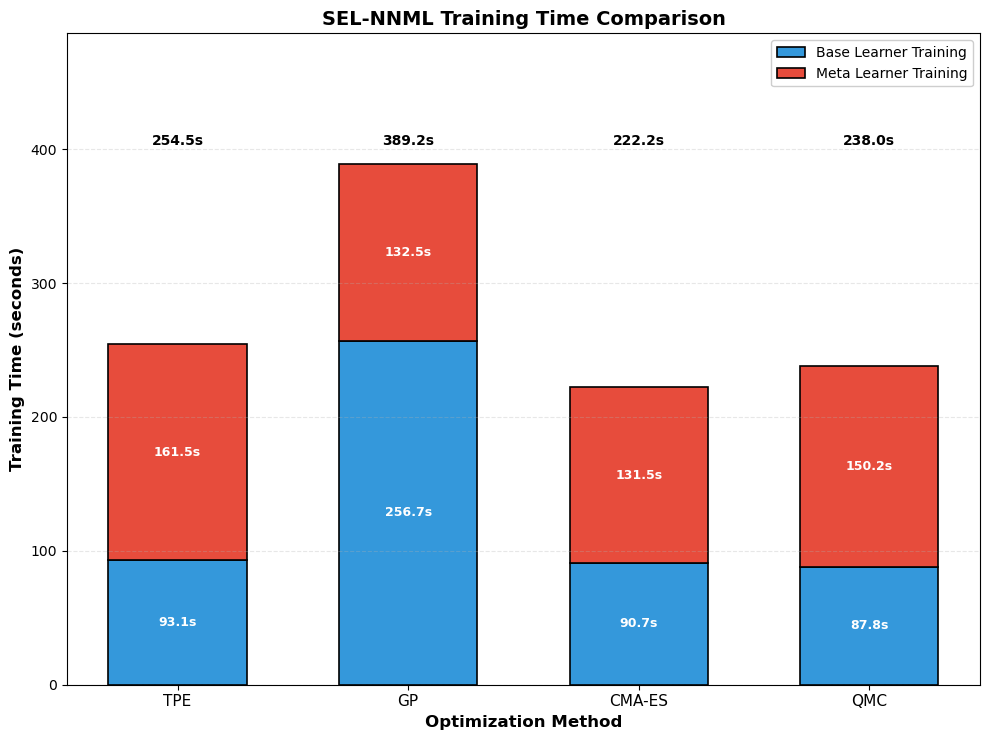

In [170]:
fig, ax = plt.subplots(figsize=(10, 7.5))

samplers_list = times_df['Sampler'].values
base_times = times_df['Base Models Training Time (seconds)'].values
meta_times = times_df['Meta Model Training Time (seconds)'].values

x = np.arange(len(samplers_list))
width = 0.6

bars1 = ax.bar(x, base_times, width, label='Base Learner Training', 
               color='#3498db', edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x, meta_times, width, bottom=base_times, 
               label='Meta Learner Training', color='#e74c3c', edgecolor='black', linewidth=1.2)

max_total = (base_times + meta_times).max()
label_offset = max_total * 0.03

for i, (b, m) in enumerate(zip(base_times, meta_times)):
    total = b + m
    ax.text(i, b/2, f'{b:.1f}s', ha='center', va='center', 
            fontweight='bold', fontsize=9, color='white')
    ax.text(i, b + m/2, f'{m:.1f}s', ha='center', va='center', 
            fontweight='bold', fontsize=9, color='white')
    ax.text(i, max_total + label_offset, f'{total:.1f}s', ha='center', 
            va='bottom', fontweight='bold', fontsize=10)

ax.set_xlabel('Optimization Method', fontsize=12, fontweight='bold')
ax.set_ylabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('SEL-NNML Training Time Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(samplers_list, fontsize=11)
ax.legend(fontsize=10, loc='upper right', framealpha=0.95)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, max_total * 1.25)

plt.tight_layout()
plt.show()

### 5.3 Save Training Time Plot

In [171]:
plt.figure(figsize=(10, 7.5))
x = np.arange(len(samplers_list))
bars1 = plt.bar(x, base_times, width, label='Base Learner Training', 
                color='#3498db', edgecolor='black', linewidth=1.2)
bars2 = plt.bar(x, meta_times, width, bottom=base_times, 
                label='Meta Learner Training', color='#e74c3c', edgecolor='black', linewidth=1.2)

for i, (b, m) in enumerate(zip(base_times, meta_times)):
    total = b + m
    plt.text(i, b/2, f'{b:.1f}s', ha='center', va='center', 
             fontweight='bold', fontsize=9, color='white')
    plt.text(i, b + m/2, f'{m:.1f}s', ha='center', va='center', 
             fontweight='bold', fontsize=9, color='white')
    plt.text(i, max_total + label_offset, f'{total:.1f}s', ha='center', 
             va='bottom', fontweight='bold', fontsize=10)

plt.xlabel('Optimization Method', fontsize=12, fontweight='bold')
plt.ylabel('Training Time (seconds)', fontsize=12, fontweight='bold')
plt.title('SEL-NNML Training Time Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, samplers_list, fontsize=11)
plt.legend(fontsize=10, loc='upper right', framealpha=0.95)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.ylim(0, max_total * 1.25)
plt.tight_layout()

time_plot_path = os.path.join(out_dir, 'sel_nnml_training_times.png')
plt.savefig(time_plot_path, dpi=300, bbox_inches='tight')
print(f'Training time plot saved to: {time_plot_path}')
plt.close()

Training time plot saved to: ../artifacts/ds1/visualizations/sel_nnml_training_times.png


## 6. Feature Importance Visualizations

In [172]:
# Load feature importance data for all samplers
feature_importance = {}
for sampler in ['TPE', 'GP', 'CMA-ES', 'QMC']:
    sampler_folder = sampler.lower().replace("-", "")
    fi_path = f'../artifacts/ds1/models/{sampler_folder}/sel-nnml_feature_importance.csv'
    if os.path.exists(fi_path):
        feature_importance[sampler] = pd.read_csv(fi_path)
        print(f"✓ Loaded {sampler} feature importance: {feature_importance[sampler].shape}")
    else:
        print(f"⚠ Feature importance file not found: {fi_path}")

# Select which sampler to visualize
SELECTED_SAMPLER = 'TPE'
if SELECTED_SAMPLER in feature_importance:
    fi_df = feature_importance[SELECTED_SAMPLER]
    print(f"\nUsing {SELECTED_SAMPLER} for visualizations")
else:
    print(f"⚠ {SELECTED_SAMPLER} data not available")

✓ Loaded TPE feature importance: (16, 3)
✓ Loaded GP feature importance: (16, 3)
✓ Loaded CMA-ES feature importance: (16, 3)
✓ Loaded QMC feature importance: (16, 3)

Using TPE for visualizations


### 6.1 Horizontal Bar Chart with Color Gradient

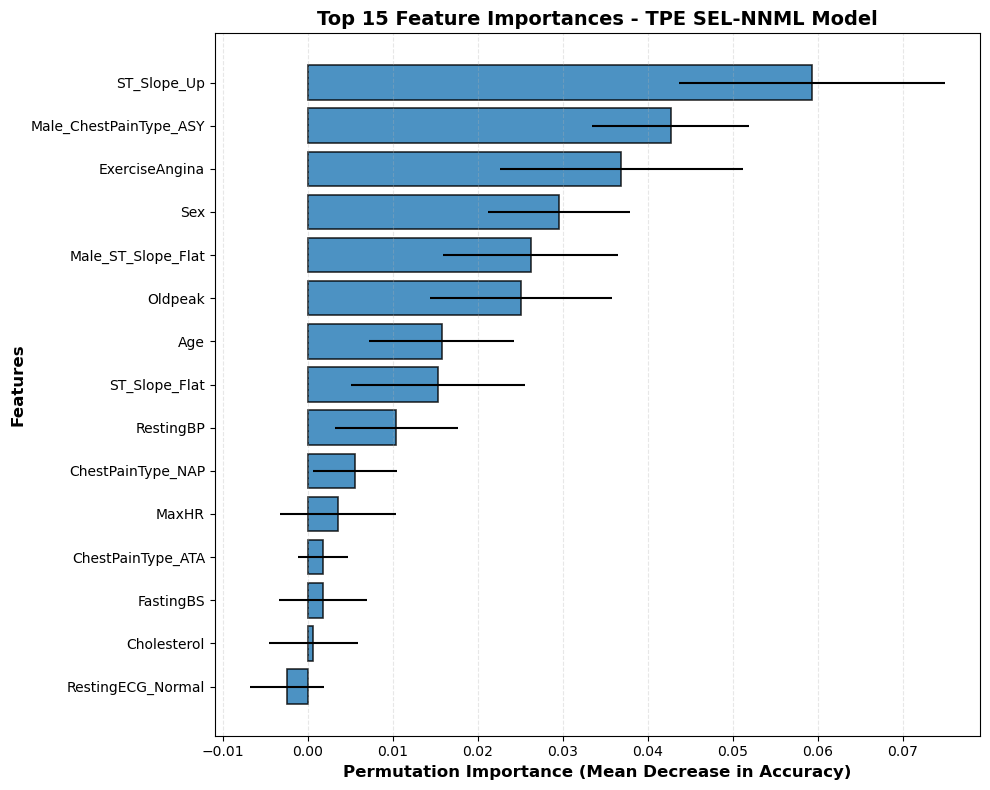

In [173]:
fig, ax = plt.subplots(figsize=(10, 8))

top_n = 15
top_features = fi_df.head(top_n)

y_pos = np.arange(len(top_features))
bars = ax.barh(y_pos, top_features['Importance Mean'].values, 
               xerr=top_features['Importance Std'].values,
               align='center', alpha=0.8, edgecolor='black', linewidth=1.2)

ax.set_yticks(y_pos)
ax.set_yticklabels(top_features['Feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Permutation Importance (Mean Decrease in Accuracy)', fontsize=12, fontweight='bold')
ax.set_ylabel('Features', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Feature Importances - {SELECTED_SAMPLER} SEL-NNML Model', 
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

### 6.2 Cumulative Feature Importance Analysis

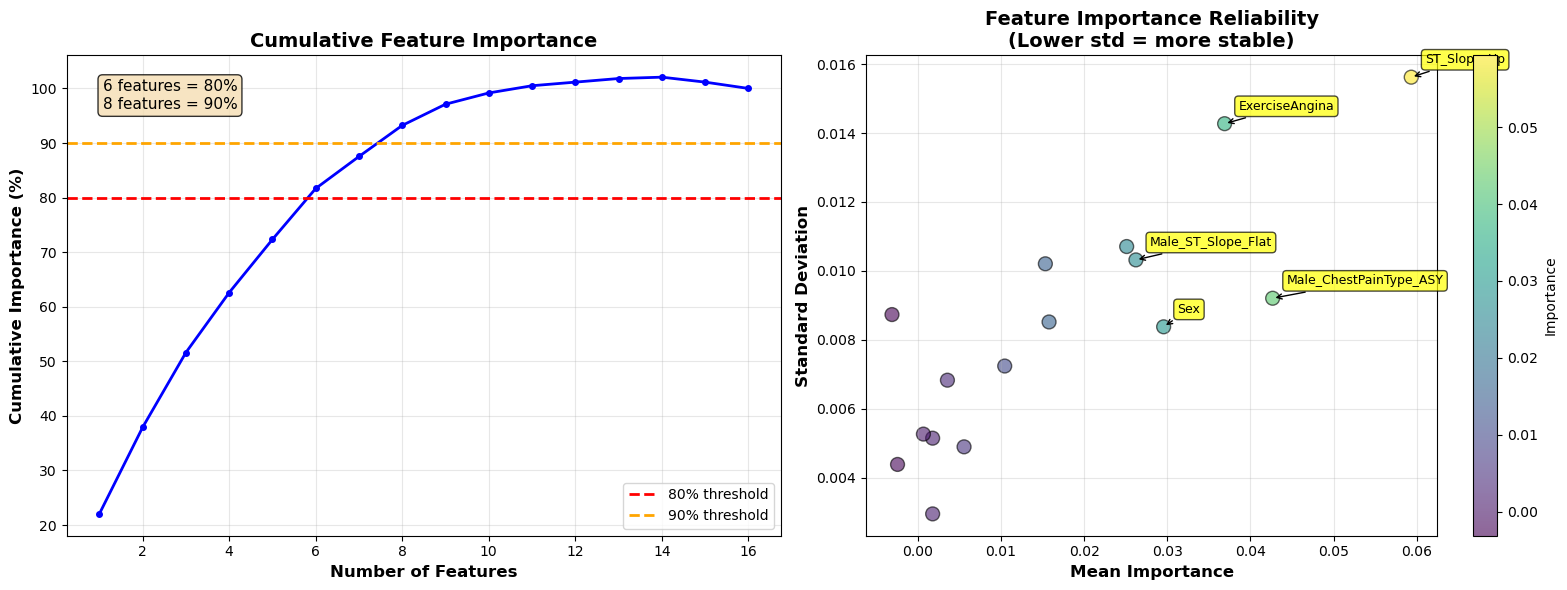

In [174]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Cumulative importance
sorted_importance = fi_df.sort_values('Importance Mean', ascending=False)
cumulative_importance = np.cumsum(sorted_importance['Importance Mean'].values)
cumulative_importance_normalized = cumulative_importance / cumulative_importance[-1] * 100

ax1.plot(range(1, len(cumulative_importance_normalized) + 1), cumulative_importance_normalized, 
         'b-', linewidth=2, marker='o', markersize=4, 
         markevery=max(1, len(cumulative_importance_normalized)//20))
ax1.axhline(y=80, color='r', linestyle='--', linewidth=2, label='80% threshold')
ax1.axhline(y=90, color='orange', linestyle='--', linewidth=2, label='90% threshold')
ax1.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cumulative Importance (%)', fontsize=12, fontweight='bold')
ax1.set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

n_features_80 = np.argmax(cumulative_importance_normalized >= 80) + 1
n_features_90 = np.argmax(cumulative_importance_normalized >= 90) + 1
ax1.text(0.05, 0.95, f'{n_features_80} features = 80%\n{n_features_90} features = 90%',
         transform=ax1.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Right: Reliability plot
ax2.scatter(fi_df['Importance Mean'], fi_df['Importance Std'],
            alpha=0.6, s=100, c=fi_df['Importance Mean'], cmap='viridis', edgecolors='black')

top_5 = fi_df.head(5)
for idx, row in top_5.iterrows():
    ax2.annotate(row['Feature'], 
                xy=(row['Importance Mean'], row['Importance Std']),
                xytext=(10, 10), textcoords='offset points', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

ax2.set_xlabel('Mean Importance', fontsize=12, fontweight='bold')
ax2.set_ylabel('Standard Deviation', fontsize=12, fontweight='bold')
ax2.set_title('Feature Importance Reliability\n(Lower std = more stable)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
plt.colorbar(ax2.collections[0], ax=ax2, label='Importance')

plt.tight_layout()
plt.show()

### 6.2 Cumulative Feature Importance Analysis

/tmp/ipykernel_1711003/3200680430.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')  # Blue (cold) to Red (hot)


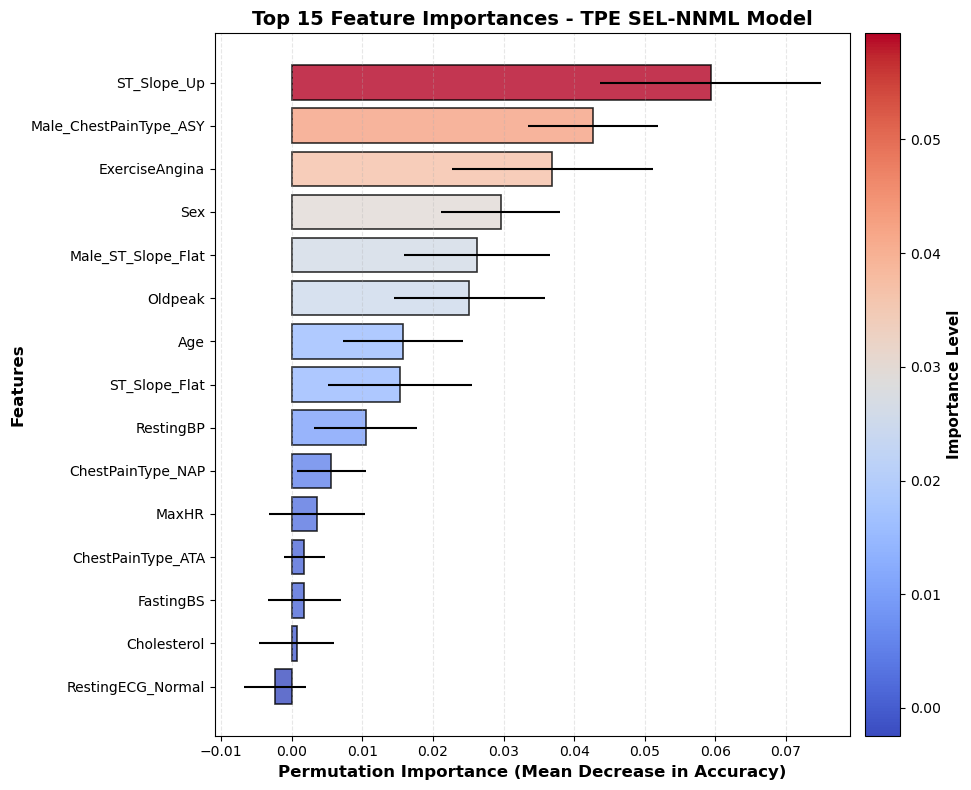

In [175]:
# Horizontal bar chart with color gradient from cold (blue) to hot (red)
import matplotlib.cm as cm
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(10, 8))

# Get top 15 features
top_n = 15
top_features = fi_df.head(top_n)

# Create color gradient from cold (blue) to hot (red)
norm = mcolors.Normalize(vmin=top_features['Importance Mean'].min(), 
                         vmax=top_features['Importance Mean'].max())
cmap = cm.get_cmap('coolwarm')  # Blue (cold) to Red (hot)
colors = [cmap(norm(val)) for val in top_features['Importance Mean'].values]

# Create horizontal bar plot
y_pos = np.arange(len(top_features))
bars = ax.barh(y_pos, top_features['Importance Mean'].values, 
               xerr=top_features['Importance Std'].values,
               align='center', alpha=0.8, edgecolor='black', linewidth=1.2,
               color=colors)

ax.set_yticks(y_pos)
ax.set_yticklabels(top_features['Feature'].values)
ax.invert_yaxis()  # Highest importance at top
ax.set_xlabel('Permutation Importance (Mean Decrease in Accuracy)', fontsize=12, fontweight='bold')
ax.set_ylabel('Features', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Feature Importances - {SELECTED_SAMPLER} SEL-NNML Model', 
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add colorbar to show the gradient scale
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label('Importance Level', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

### 6.1 Horizontal Bar Chart with Error Bars

In [176]:
# Load feature importance data for all samplers
feature_importance = {}
for sampler in ['TPE', 'GP', 'CMA-ES', 'QMC']:
    sampler_folder = sampler.lower().replace("-", "")
    fi_path = f'../artifacts/ds1/models/{sampler_folder}/sel-nnml_feature_importance.csv'
    if os.path.exists(fi_path):
        feature_importance[sampler] = pd.read_csv(fi_path)
        print(f"✓ Loaded {sampler} feature importance: {feature_importance[sampler].shape}")
    else:
        print(f"⚠ Feature importance file not found: {fi_path}")

# Select which sampler to visualize (can change this)
SELECTED_SAMPLER = 'TPE'
if SELECTED_SAMPLER in feature_importance:
    fi_df = feature_importance[SELECTED_SAMPLER]
    print(f"\nUsing {SELECTED_SAMPLER} for visualizations")
else:
    print(f"⚠ {SELECTED_SAMPLER} data not available")

✓ Loaded TPE feature importance: (16, 3)
✓ Loaded GP feature importance: (16, 3)
✓ Loaded CMA-ES feature importance: (16, 3)
✓ Loaded QMC feature importance: (16, 3)

Using TPE for visualizations
